### **Deep Reinforcement Learning(DRL)** Code

---

- DRL aims to **solve MDP**(Markov Decision Process) problems. That is, DRL aims to **find an optimal policy**.
- In this notebook, we aims to implement the following DRL algorithm : `DQN`
- As an environment in which agents will interact, we will use [OpenAI Gymnasium library](https://gymnasium.farama.org/)

## Requirement

In [1]:
!pip install gymnasium
!pip install opencv-python==4.8.0.74

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 69.9 MB/s eta 0:00:00a 0:00:01m
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replac

In [2]:
import gymnasium as gym
import numpy as np
import random
import time, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque #double-ended queue

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image

## Utils

In [3]:
# learning rate/epsilon scheduler (linear)
# decay linearly from 'initial' to 'final'
def linear_schedule(episode, max_episode, initial, final):
    start, end = initial, final
    if episode < max_episode:
        return (start*(max_episode-episode) + end*episode) / max_episode
    else:
        return end

In [4]:
# plot the experiment results (rewards)
# given the list of rewards, plot the highest, lowest, and mean reward graph.
def plot(rewards, title:str, save_path=None):  
      
    plt.figure(figsize=[4,2], dpi=300)
    plt.title(title , fontsize=9)
    # plot reward
    high_rewards= np.max(rewards , axis= 0)
    low_rewards= np.min(rewards , axis= 0)
    mean_rewards= np.mean(rewards , axis= 0)
    
    plt.xlabel('Episodes', fontsize=7)
    plt.ylabel('Total Rewards', fontsize=7)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    plt.grid(linewidth=.1)

    x= np.arange(1, len(rewards[0])+1)
    plt.plot(x, high_rewards, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, low_rewards, 'b-', linewidth=.1, alpha=0.2)
    plt.plot(x, mean_rewards, 'b-', linewidth=.2)
    
    if save_path!=None:
        plt.savefig(save_path, format='png')
        
    plt.show()

In [5]:
# create a GIF that shows how agent interacts with environment (play 1 episode)
# given the trained agent and environment, the agent interact with the environment and save into a GIF file 
def play_and_save(env, agent, name='', seed=None):
    
    render_images = []
    total_reward = 0
    state, _ = env.reset(seed=seed)
    image_array = env.render()
    render_images.append(PIL.Image.fromarray(image_array))

    terminated, truncated = False, False
    agent.behavior_Q = agent.behavior_Q.to('cpu')
    
    # episode start
    while not terminated and not truncated:
        action = agent.get_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        image_array = env.render()
        render_images.append(PIL.Image.fromarray(image_array))
    # episode finished
    filename = 'play_' + name + '.gif'

    # create and save GIF
    render_images[0].save(filename, save_all=True, optimize=False, append_images=render_images[1:], duration=500, loop=0)

    print(f'Episode Length : {len(render_images)-1}')
    print(f'Total rewards : {total_reward}')
    print('GIF is made successfully!')

    return filename

## Objective funtion of `DQN`
> $L(\theta)= \, \frac{1}{|B|}\sum_{i \in B}[$
<font color=blue>$r_{i+1} + \gamma\, \underset{a}{max}\, \hat{Q}_{\hat{\theta}}(s_{i+1},a)$</font>
 $ - \, Q_{\theta}(s_i,a_i)]^2$
 <br>
 where $B$ is the sampled mini-batch from the replay buffer.


In [6]:
class DQN_net(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN_net, self).__init__()
        self.relu = F.relu
        self.linear_1 = nn.Linear(state_dim,128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        
    def forward(self, x):
        x = self.relu(self.linear_1(x))
        x = self.relu(self.linear_2(x))
        x = self.linear_3(x)

        return x

#### DuelingDQN

In [7]:
class DuelingDQN_net(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN_net, self).__init__()

        # Common feature layer
        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Outputs a single value for the state
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)  # Outputs advantage values for each action
        )
        
    def forward(self, x):
        features = self.feature(x)
        
        # Separate into value and advantage
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        
        # Combine value and advantage to get Q-values
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values

target_q = self.target_Q.to(device)(next_state_arr).gather(1, next_action.unsqueeze(1)).squeeze(1)

*  next_action은 torch.argmax로 계산된 action index(tensor)로, 각 batch 항목에 대해 가장 큰 Q값을 가지는 action index를 나타냄./
* 이 값의 shape은 [batch_size]인데, .unsqueeze(1)을 통해 [batch_size,1]로 변경/
* .unsqueeze(dim)은 PyTorch에서 tensor의 차원을 늘려주는 함수. dim 위치에 새로운 차원 추가. /
* dim은 추가하고 싶은 차원의 인덱스 의미/
* 음수 입력하면 뒤에서부터 차원 추가
---

import torch

#### 1차원 텐서 예시
x = torch.tensor([1, 2, 3])  # shape: [3]

#### 0번째 위치에 차원 추가
x_unsqueezed_0 = x.unsqueeze(0)  # shape: [1, 3]

#### 1번째 위치에 차원 추가
x_unsqueezed_1 = x.unsqueeze(1)  # shape: [3, 1]

print(x_unsqueezed_0)  # tensor([[1, 2, 3]])
print(x_unsqueezed_1)  # tensor([[1], [2], [3]])

---

tensor의 shape는 [행, 열]


gather()


squeeze()

In [8]:
# Agent that will be interact with environment and trained
class DQN:    
    def __init__(self,  state_dim, action_dim, gamma):
        self.behavior_Q = DuelingDQN_net(state_dim, action_dim)
        self.target_Q   = DuelingDQN_net(state_dim, action_dim)
        
        self.gamma = gamma    
        self.state_dim =  state_dim
        self.action_dim = action_dim
    
    # get action from the Epsilon-greedy policy
    def get_action(self, state, epsilon=0):
        action_logit = self.behavior_Q.to('cpu')(torch.FloatTensor(np.array([state])))  # input shape = (batch, state_dim)
        explore = np.random.rand()
        if explore < epsilon:
            # random action with probability epsilon (Exploration)
            return np.random.choice(self.action_dim)
        else:
            # greedy action with probability (1 - epsilon) (Exploitation)
            return torch.argmax(action_logit, dim=1)[0].detach().numpy()
    
    # update Q network 1-step
    def update(self, optimizer, buffer, batch_size, device):
        state_arr, action_arr, reward_arr, next_state_arr, done_arr = buffer.sampling(batch_size,device)

        predict = torch.sum(self.behavior_Q.to(device)(state_arr)*action_arr, dim=1)
        next_action = torch.argmax(self.behavior_Q.to(device)(next_state_arr), dim=1)
        #target_q = torch.max(self.target_Q.to(device)(next_state_arr), dim=1)[0]
        target_q = self.target_Q.to(device)(next_state_arr).gather(1, next_action.unsqueeze(1)).squeeze(1)
        target = reward_arr + self.gamma*target_q*(1-done_arr)
        td     = target.detach() - predict
        loss = torch.mean(td**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
     
    # update target network
    def update_target(self, ):
        self.target_Q.load_state_dict(self.behavior_Q.state_dict())
    
    # train agent
    def train(self, env, max_episode, evaluate_period, evaluate_num, buffer_size, initial_epsilon, final_epsilon, initial_lr, final_lr,
              update_period, target_update_period, batch_size=64, device='cpu'):
        
        start= time.time()  
        one_hot_action = np.eye(self.action_dim) # identity matrix for one-hot encoding of action (ex. 0->(1,0))
        reward_list = [] # evaluation result(reward) will be inserted during the training

        replay_buffer = ReplayBuffer(capacity=buffer_size)
        optimizer = torch.optim.Adam(self.behavior_Q.parameters(), lr=initial_lr)
        self.update_target()

        for episode in range(max_episode):
            # new episode start
            done = False
            episode_length = 0

            epsilon = linear_schedule(episode, max_episode//2, initial_epsilon, final_epsilon)
            lr      = linear_schedule(episode, max_episode, initial_lr, final_lr)
            optimizer.learning_rate = lr
            
            state, info = env.reset()

            # interact with environment and train
            while not done:
                action = self.get_action(state, epsilon)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated 
                episode_length += 1

                replay_buffer.store([state, one_hot_action[action], reward, next_state, terminated])
                
                # update behavior
                if replay_buffer.size() >= batch_size and episode_length%update_period == 0:
                    self.update(optimizer, replay_buffer, batch_size, device)
                # update target
                if replay_buffer.size() >= batch_size and episode_length%target_update_period == 0:
                    self.update_target()

                state = next_state
                
            # episode finished and evaluate the current policy
            if (episode+1)%evaluate_period == 0 :
                reward = self.test(env, evaluate_num)
                reward_list.append(reward)
        
        end= time.time()  
        print(f'Training time : {(end-start)/60:.2f}(min)')
        
        return reward_list
    
    # evaluate current policy
    # return average reward value over the several episodes
    def test(self, env, evaluate_num=10):

        reward_list = []

        for episode in range(evaluate_num):
            # new episode start
            done = False
            episode_reward = 0

            state, info = env.reset()
            while not done:
                action = self.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                episode_reward += reward
                state = next_state

            # episode finished
            reward_list.append(episode_reward)

        return np.mean(reward_list)

test할 때 입실론 greedy 쓸 필요 없음 ( exploration 없이 policy evaluation하고 싶기 때문에) 

test 함수는 꼭 따로 만들어줘야 함! 

몇 episode마다 test해줄건지 설정!! => evaluate_num (hyperparamter)

In [9]:
# replay buffer for experience replay
class ReplayBuffer():
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def store(self, transition):
        self.buffer.append(transition)

    def sampling(self, batch_size, device):
        experience_samples = random.sample(self.buffer, batch_size)
        state_arr, action_arr, reward_arr, next_state_arr, done_arr = map(np.asarray, zip(*experience_samples))

        state_arr      = torch.FloatTensor(state_arr).to(device)
        action_arr       = torch.FloatTensor(action_arr).to(device)
        reward_arr       = torch.FloatTensor(reward_arr).to(device)
        next_state_arr = torch.FloatTensor(next_state_arr).to(device)
        done_arr         = torch.FloatTensor(done_arr).to(device)

        return state_arr, action_arr, reward_arr, next_state_arr, done_arr

    def size(self):
        return len(self.buffer)

## **Train** Agent

In [10]:
# hyperparameter 
max_episode = 1000  # the number of episodes that agent will be trained
evaluate_period = 5   # episode period that agent's policy will be evaluated
evaluate_num    = 10   # the number of episodes that agent will be evaluated

initial_lr = 1e-3    # starting learning rate
final_lr   = 1e-4    # final learning rate
initial_epsilon = 1.0    # starting epsilon
final_epsilon   = 0.01    # final epsilon
gamma = 0.99   # gamma : reward discount rate

# Replay Buffer
buffer_size = 100000    # size of the replay buffer 
batch_size  = 64   # size of the mini-batch

# Target network
target_update_period = 10  # period of episode to update target network
update_period = 1 # period of episode that agent will be trained

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
repeat = 3 # repeat same experiment for the reliable result

In [11]:
# train : DQN
reward_list =[]
for i in range(repeat):
    # control randomness for reproducibility
    seed = 100*(i+1)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    agent = DQN(env.observation_space.shape[0], env.action_space.n, gamma)
    reward = agent.train( env, max_episode, evaluate_period, evaluate_num, buffer_size, initial_epsilon, final_epsilon, initial_lr, final_lr, 
                  update_period, target_update_period, batch_size, device)
    reward_list.append(reward)

Training time : 29.14(min)
Training time : 28.53(min)
Training time : 42.05(min)


## **Results**

### Plot the results

In [12]:
# create folder to save the result
save_folder = '/home/work/DLmath/Seulbin/DRLstudy/20241106_DQN/result'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

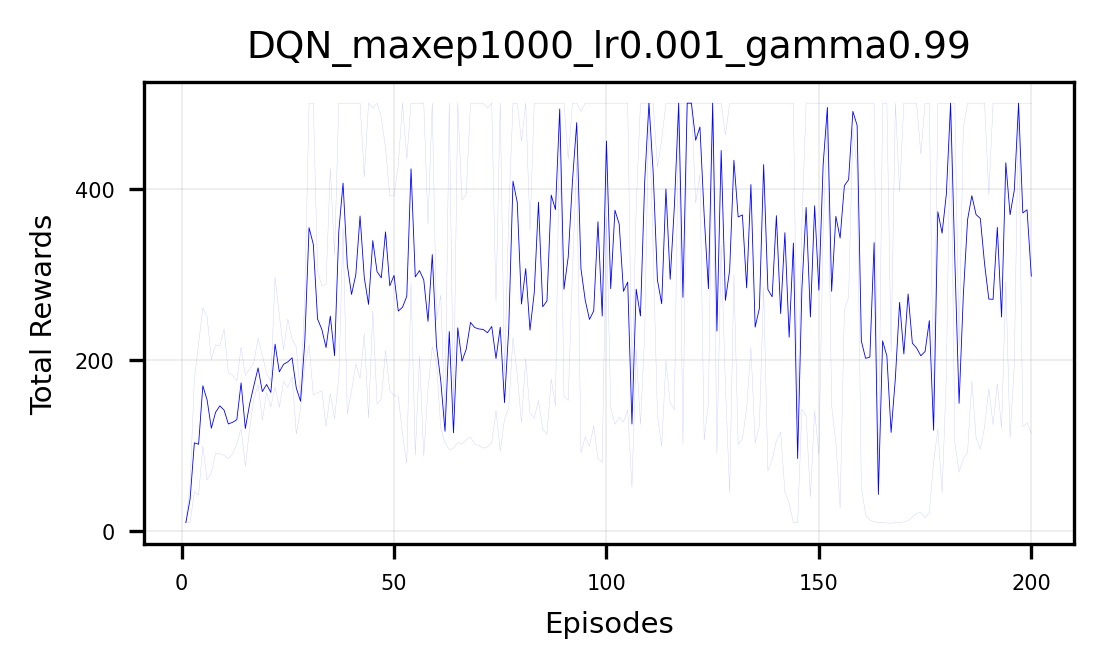

In [13]:
save_file = 'DQN_20241111_1.png'.format(max_episode, initial_lr, gamma)
save_path  = os.path.join(save_folder, save_file)

plot(reward_list, 'DQN_maxep{}_lr{}_gamma{}'.format(max_episode, initial_lr, gamma), save_path=save_path)

### Test the trained agent and save it into a GIF.

In [14]:
'''env = gym.make('CartPole-v1', render_mode='rgb_array')
play = play_and_save(env, agent, 'DQN', seed=8)
Image(open(play,'rb').read())'''

"env = gym.make('CartPole-v1', render_mode='rgb_array')\nplay = play_and_save(env, agent, 'DQN', seed=8)\nImage(open(play,'rb').read())"